Вы работаете в приложении по доставке готовых продуктов. К вам пришел коллега с результатами двух тестов:

- В первом тестировали разрешение фотографий блюд в приложении: пользователям показывались либо прямоугольные, либо новые квадратные    
- Во втором: была обновлена кнопка заказа, и часть юзеров видела старый вариант, а часть – новый  
Коллега пришел к вам с просьбой: он посмотрел на графики и предположил, что среди групп могут встретиться различия.  

Ваша задача – помочь ему проверить гипотезы, сделать соответствующие выводы на основе статистических тестов и принять решения.

In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import iqr
import scipy
import pingouin as pg
from statsmodels.stats.multicomp import pairwise_tukeyhsd

### Нужно проверить, какой формат фотографий блюд является наилучшим, т.е. в какой из групп в среднем покупали больше всего. Всего пользователям показывались три варианта:

- A – прямоугольные 16:9
- B – квадратные
- C – прямоугольные 12:4

Описание данных:

- id – id клиента в эксперименте
- group – в каком разрешении показывались картинки (A – прямоугольные 16:9, B – квадратные, C – прямоугольные 12:4)
- events – сколько блюд суммарно было заказано за период

In [50]:
df1 = pd.read_csv('5_task_1.csv')

In [51]:
df1.head()

,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30
3,22633,A,37
4,28071,A,38


<AxesSubplot:xlabel='events', ylabel='group'>

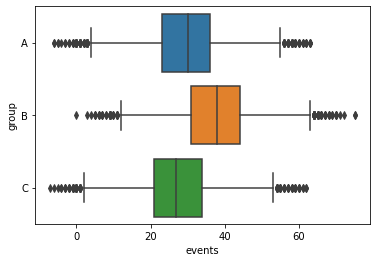

In [52]:

sns.boxplot(data=df1, y='group', x='events')

Для проведения тестов, где групп больше двух t-test не подходит - тк с увеличением числа групп растет вероятность ошибки первого рода. В данном случае необходимо использовать дисперсионный анализ (aka ANOVA).  

Как и для t-test должны выполняться требования:
1. Дисперсии внутри наших групп должны быть примерно одинаковы (требование гомогенности дисперсий). Проверить можно с помощью критерия Левена и критерия Бартлетта
2. Если объемы групп недостаточно большие (меньше 30) и не совпадают по размерам, то важно соблюдать требование о **нормальности распределения** выборок.

In [53]:
# посмотрим размеры групп
df1.group.value_counts()

A    10000
B    10000
C    10000
Name: group, dtype: int64

Проверка на гомогенность дисперсий (примерное равенство). критерий Левена


In [54]:
A = df1[df1.group == 'A'].events
B = df1[df1.group == 'B'].events
C = df1[df1.group == 'C'].events

scipy.stats.levene(A, B, C)

LeveneResult(statistic=2.2622596339318037, pvalue=0.1041327199523974)

Несмотря на то, что размеры групп совпадают и велики по размеру оценим их лишний раз на нормальность

Обычно нормальность тестируют с помощью теста Шапиро-Уилка (scipy.stats.shapiro()), однако на больших выборках этот тест слишком рьяно находит отклонения от нормальности! Поэтому используйте функцию scipy.stats.normaltest() - она больше адаптирована к большим выборкам. Также можете сделать это через пакет pingouin: pingouin.normality

для визуальной оценки можно построить qqplot

In [55]:
#! нулевая гипотеза, что ГС нормально распределена
print(scipy.stats.normaltest(A))
print(scipy.stats.normaltest(B))
print(scipy.stats.normaltest(C))

NormaltestResult(statistic=2.1034599402238734, pvalue=0.3493328906085719)
NormaltestResult(statistic=0.8410715800223014, pvalue=0.6566948749848232)
NormaltestResult(statistic=3.243725809054571, pvalue=0.19753037588314626)


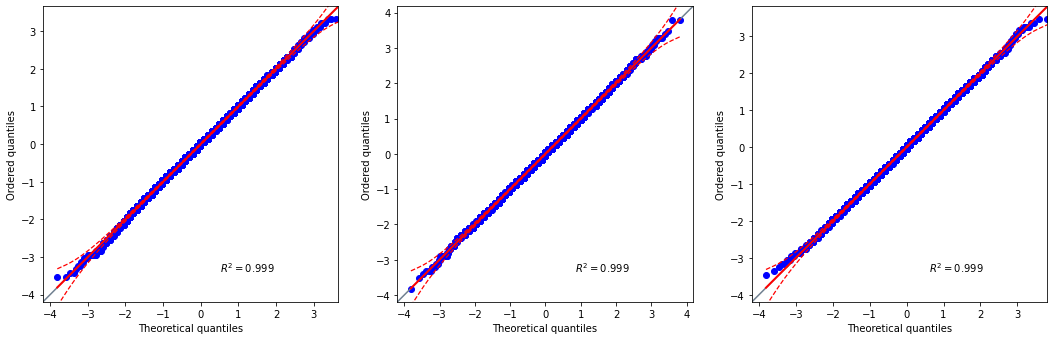

In [56]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
ax1 = pg.qqplot(A, ax=ax1)
ax2 = pg.qqplot(B, ax=ax2)
ax3 = pg.qqplot(C, ax=ax3)

Проводим однофакторный дисп анализ f_oneway. Проверяет общую гипотезу о том, что в выборках есть отличия. Важно помнить, что при сревнении более двух групп, p-value надо корректировать, т.к. растет вероятность ошибки 1 рода. есть корректировки 1) Бонферони 2) Тьюки

Проблема метода Бонферони: при достаточно большом количестве попарных сравнений метод становится слишком консервативным: растет вероятность ошибки II рода, и мы уже не можем отвергнуть нулевую гипотезу даже при выраженных различиях между группами.

Тьюки Фактически рассчитывается по той же формуле, что и t-критерий, но несколько иначе рассчитывается стандартная ошибка – в результате критерий Тьюки более консервативен, чем обычный t-критерий, но гораздо менее консервативен по сравнению с поправкой Бонферрони.

In [57]:
scipy.stats.f_oneway(A, B, C)

F_onewayResult(statistic=2886.166657438961, pvalue=0.0)

Т.к дисп анализ показал, что различия в между группами есть (p_value = 0.0 < $\alpha$ = 0.05), то теперь можем проверить попарное различие выборок через критерий Тьюки. если reject показывает True, то значимо отличаются

In [58]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [59]:
print(pairwise_tukeyhsd(df1.events, df1.group))

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper  reject
----------------------------------------------------
     A      B    8.034  -0.0   7.7038  8.3642   True
     A      C  -2.1093  -0.0  -2.4395 -1.7791   True
     B      C -10.1433  -0.0 -10.4735 -9.8131   True
----------------------------------------------------


In [60]:
df1.groupby('group')['events'].mean()

group
A    29.5796
B    37.6136
C    27.4703
Name: events, dtype: float64

Как мы видим все группы между собой стат. значимо различаются. **Соотвественно будем использовать квадратные фото (B), тк средее число заказов выше чем остальных**

### Во втором эксперименте требуется проверить, как пользователи отреагируют на **изменение формата кнопки оформления заказа, с разбивкой по сегменту клиента**.
Проводим двухфакторный анализ.  
Требования: 
- Дисперсии внутри наших групп должны быть примерно одинаковы (требование гомогенности дисперсий). Проверить можно с помощью критерия Левена и критерия Бартлетта
- Если объем выборки недостаточно большой (меньше 30), то важно соблюдать требование о нормальности распределения двух выборок.

Во втором датафрейме требования не проверял, т.к. предполагается что данные им соответствуют

In [61]:
df2 = pd.read_csv('5_task_2.csv')

In [62]:
df2.head()

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0


Описание данных:  
- id – id клиента в эксперименте
- segment – сегмент (high/low)
- group – вид кнопки (control – старая версия, test – новая версия)
- events – сколько блюд суммарно было заказано за период

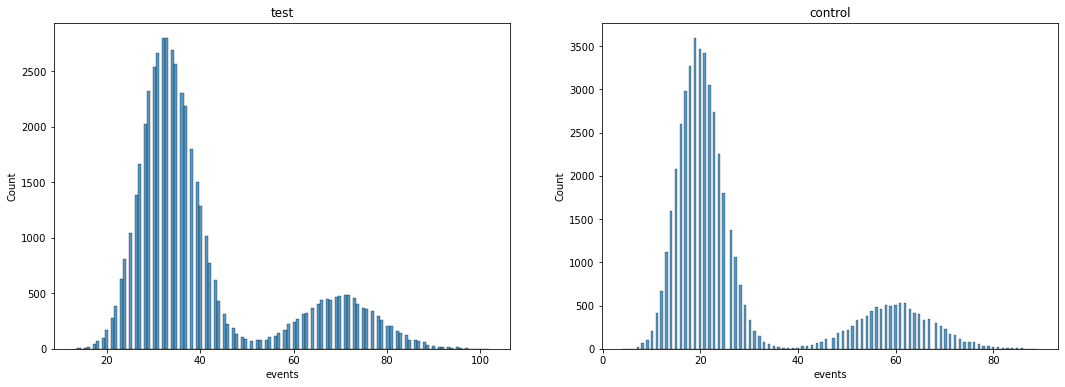

In [63]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

ax1 = sns.histplot(df2[df2.group == 'test'].events, kde=False, ax=ax1)
ax1.set_title('test')
ax2 = sns.histplot(df2[df2.group == 'control'].events, kde=False, ax=ax2)
ax2.set_title('control')
plt.show()

In [64]:
df2.groupby(['group', 'segment'])['events'].describe()

count       mean       std   min   25%   50%   75%    max
group   segment                                                             
control high     10000.0  59.970800  7.805347  31.0  55.0  60.0  65.0   89.0
        low      40000.0  20.031575  4.473576   4.0  17.0  20.0  23.0   41.0
test    high     10000.0  69.938500  8.403974  40.0  64.0  70.0  76.0  102.0
        low      40000.0  33.025925  5.720845  13.0  29.0  33.0  37.0   59.0

In [65]:
pg.anova(data=df2, dv='events', between=['group', 'segment'])

,Source,SS,DF,MS,F,p-unc,np2
0,group,3.837195e+06,1.0,3.837195e+06,112031.864119,0.000000e+00,0.528383
1,segment,2.362480e+07,1.0,2.362480e+07,689756.377484,0.000000e+00,0.873383
2,group * segment,3.664244e+04,1.0,3.664244e+04,1069.823273,2.060261e-233,0.010585
3,Residual,3.424956e+06,99996.0,3.425093e+01,NaN,NaN,NaN


По anova видим что есть стат значимые различия по обоим факторам и их взаимодействию. Теперь можно провести Тьюки, чтобы понять между какими группами есть стат различия и какие они

In [66]:
df2['combination'] = df2.group + ' / ' + df2.segment

In [67]:
df2.head()

,id,group,segment,events,combination
0,83440,test,high,78.0,test / high
1,96723,test,high,71.0,test / high
2,68719,test,high,80.0,test / high
3,50399,test,high,80.0,test / high
4,95613,test,high,78.0,test / high


In [68]:
pairwise_tukeyhsd(df2.events, df2.combination).summary()

# - **Как по таблице понять, где различия значимые?**
#     Смотрим на столбец **reject**. Если там стоит True - различия значимые.
    
# - **Как по таблице понять характер различий в средних?**
#     Столбец **meandiff** отражает различие в средних между **второй и первой группой, именно в таком порядке.**

group1,group2,meandiff,p-adj,lower,upper,reject
control / high,control / low,-39.9392,-0.0,-40.1073,-39.7711,True
control / high,test / high,9.9677,-0.0,9.7551,10.1803,True
control / high,test / low,-26.9449,-0.0,-27.113,-26.7768,True
control / low,test / high,49.9069,-0.0,49.7388,50.075,True
control / low,test / low,12.9944,-0.0,12.888,13.1007,True
test / high,test / low,-36.9126,-0.0,-37.0807,-36.7445,True


<AxesSubplot:xlabel='group', ylabel='events'>

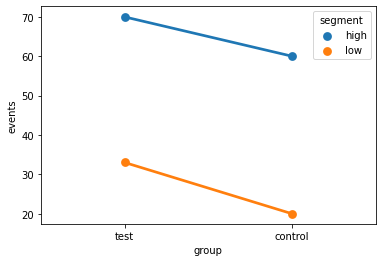

In [69]:
sns.pointplot(data=df2, y='events', x='group', hue='segment')

Фактор group оказался значимым, фактор segment – значимым, их взаимодействие – значимо.  
Судя по графику, для всех групп среднее значение events увеличилось, поэтому решение: 
**выкатываем новую версию.**